In [49]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import folium
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import seaborn as sns
from sklearn.linear_model import LinearRegression
from folium import plugins

In [50]:
# for a wider display, making it easier to view large DataFrames without line breaks.
pd.set_option('display.width', 1000)

In [51]:
data_hanze = pd.read_csv('../data/source/hanze_all.csv')
print(data_hanze.head())

     ID Country code  Year Country name  Start date    End date   Type               Flood source                           Regions affected (v2010)                           Regions affected (v2021)  Area flooded  Fatalities  Persons affected  Losses (nominal value) Losses (original currency)  Losses (2020 euro)             Cause                                              Notes                                         References Changes
0  2000           AL  1946      Albania  1946-10-11  1946-11-15  River                        NaN  AL011;AL012;AL013;AL015;AL021;AL022;AL031;AL03...  AL011;AL012;AL013;AL015;AL021;AL022;AL031;AL03...           NaN        15.0               NaN            1.000000e+09                        ALK          29746037.0    Heavy rainfall                                    Also landslides                                       UNDRR (2022)     New
1  2001           AL  1953      Albania  1953-12-12  1953-12-12  Flash                        NaN                 

# Basic Filtering

- Filter the data to include only rows from switzerland.
- Limit the time period to 1979-2023.

In [52]:
# Filter the data to include only rows where the 'Country name' is 'Switzerland'
data_hanze_ch = data_hanze[data_hanze['Country name'] == 'Switzerland']

# Further filter the data to include only rows where the 'Year' is between 1979 and 2023 (inclusive)
data_hanze_ch = data_hanze_ch[(data_hanze_ch['Year'] >= 1979) & (data_hanze_ch['Year'] <= 2023)]

# Print the first five rows of the filtered DataFrame to check the result
print(data_hanze_ch.head())

        ID Country code  Year Country name  Start date    End date   Type Flood source                           Regions affected (v2010)                           Regions affected (v2021)  Area flooded  Fatalities  Persons affected  Losses (nominal value) Losses (original currency)  Losses (2020 euro)             Cause                     Notes                       References Changes
2325  1453           CH  1979  Switzerland  1979-06-01  1979-06-02  Flash          NaN                                        CH061;CH065                                        CH061;CH065           NaN         0.0               NaN              34000000.0                        CHF          57319696.0  Extreme rainfall                       NaN             Rothlisberger (1991)     NaN
2326  6017           CH  1981  Switzerland  1981-07-10  1981-07-12  River          NaN                                              CH033                                              CH033           NaN         0.0        

# Missing Values

Find any missing values in the dataset and determine the total number of missing values.

In [53]:
#Missing values
missing = data_hanze_ch.isnull().sum()
total_missing = missing.sum()

print(missing)
print(total_missing)

ID                             0
Country code                   0
Year                           0
Country name                   0
Start date                     0
End date                       0
Type                           0
Flood source                  26
Regions affected (v2010)       0
Regions affected (v2021)       0
Area flooded                  44
Fatalities                     0
Persons affected              36
Losses (nominal value)         3
Losses (original currency)     3
Losses (2020 euro)             3
Cause                          0
Notes                         22
References                     0
Changes                        9
dtype: int64
146


# Data Cleaning

- Remove unnecessary columns from the dataset to focus on the relevant information.

In [54]:
data_hanze_ch = data_hanze_ch.drop(columns=['Country code'])
data_hanze_ch = data_hanze_ch.drop(columns=['Area flooded'])
data_hanze_ch = data_hanze_ch.drop(columns=['Regions affected (v2010)'])
data_hanze_ch = data_hanze_ch.drop(columns=['Persons affected'])
data_hanze_ch = data_hanze_ch.drop(columns=['Fatalities'])
data_hanze_ch = data_hanze_ch.drop(columns=['Losses (nominal value)'])
data_hanze_ch = data_hanze_ch.drop(columns=['Flood source'])
data_hanze_ch = data_hanze_ch.drop(columns=['Notes'])
data_hanze_ch = data_hanze_ch.drop(columns=['Changes'])
data_hanze_ch = data_hanze_ch.drop(columns=['Losses (2020 euro)'])
data_hanze_ch = data_hanze_ch.drop(columns=['Losses (original currency)'])

print(data_hanze_ch.head())

        ID  Year Country name  Start date    End date   Type                           Regions affected (v2021)             Cause                       References
2325  1453  1979  Switzerland  1979-06-01  1979-06-02  Flash                                        CH061;CH065  Extreme rainfall             Rothlisberger (1991)
2326  6017  1981  Switzerland  1981-07-10  1981-07-12  River                                              CH033    Heavy rainfall  Zeller and Röthlisberger (1982)
2327  1454  1984  Switzerland  1984-07-24  1984-07-25  Flash  CH021;CH031;CH040;CH052;CH053;CH054;CH055;CH06...  Extreme rainfall             Rothlisberger (1991)
2328  1455  1985  Switzerland  1985-07-04  1985-07-05  Flash                                        CH021;CH022  Extreme rainfall             Rothlisberger (1991)
2329  6019  1986  Switzerland  1986-05-23  1986-05-24  Flash                                              CH021  Extreme rainfall       Sturmarchiv Schweiz (2022)


Review again, if there are any missing values.

In [55]:
#Missing values
missing = data_hanze_ch.isnull().sum()
total_missing = missing.sum()

print(missing)
print(total_missing)

ID                          0
Year                        0
Country name                0
Start date                  0
End date                    0
Type                        0
Regions affected (v2021)    0
Cause                       0
References                  0
dtype: int64
0


Store the cleaned data in a new CSV file.

In [56]:
data_hanze_ch.to_csv('../data/generated/hanze_ch.csv', index=False)

Load the csv file with the region codes. The region codes file contains the mapping betwen the region codes in the hanze csv and coordinates.

In [57]:
regions = pd.read_csv('../data/source/regioncodes.csv')
print(regions.head())

    Code     Name
0  AD000  Andorra
1  AL011    Dibër
2  AL012   Durrës
3  AL013    Kukës
4  AL014    Lezhë


Filter the regions to include only the regions in Switzerland.

In [58]:
regions_ch = regions[regions['Code'].str[:2] == 'CH']

print(regions_ch)

      Code                              Name
137  CH011                              Vaud
138  CH012                   Valais / Wallis
139  CH013                            Genève
140  CH021                      Bern / Berne
141  CH022               Fribourg / Freiburg
142  CH023                         Solothurn
143  CH024                         Neuchâtel
144  CH025                              Jura
145  CH031                       Basel-Stadt
146  CH032                  Basel-Landschaft
147  CH033                            Aargau
148  CH040                            Zürich
149  CH051                            Glarus
150  CH052                      Schaffhausen
151  CH053            Appenzell Ausserrhoden
152  CH054             Appenzell Innerrhoden
153  CH055                        St. Gallen
154  CH056  Graubünden / Grigioni / Grischun
155  CH057                           Thurgau
156  CH061                            Luzern
157  CH062                               Uri
158  CH063

# Coordinate mapping

- Use the geopy library to retrieve the coordinates (latitude and longitude) of each canton in Switzerland.
- Nominatim is a powerful open-source geocoding service provided by the OpenStreetMap project. It allows developers to convert human-readable addresses into precise geographic coordinates and vice versa.
- The RateLimiter class is used to limit the number of requests sent to the geocoding service to avoid running into rate limits of the OSM server.
- The get_coordinates function retrieves the coordinates of a canton using the geocode function of the geolocator.

In [59]:
# Initialize the Geolocator with a user agent of your choice
geolocator = Nominatim(user_agent="my_app")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Function to retrieve the coordinates (latitude and longitude) of a canton
def get_coordinates(kanton_name):
    location = geocode(kanton_name)
    return (location.latitude, location.longitude) if location else (None, None)

# Perform geocoding for each canton and store the coordinates directly in the 'Coordinates' column
regions_ch['Coordinates'] = regions_ch['Name'].apply(get_coordinates)

print(regions_ch.head())

      Code                 Name              Coordinates
137  CH011                 Vaud  (46.6356963, 6.5320717)
138  CH012      Valais / Wallis  (46.2303063, 7.6605757)
139  CH013               Genève  (46.2017559, 6.1466014)
140  CH021         Bern / Berne  (46.8382351, 7.6004502)
141  CH022  Fribourg / Freiburg  (46.6789116, 7.1027113)


/var/folders/hc/jq_vy5cd18ncjkg4x5xgvj8w0000gn/T/ipykernel_54000/1160426924.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regions_ch['Coordinates'] = regions_ch['Name'].apply(get_coordinates)


In [60]:
# Create a dictionary to map codes to coordinates
code_to_coords = dict(zip(regions_ch['Code'], regions_ch['Coordinates']))

# Function to replace codes with coordinates
def replace_codes_with_coords(code_list):
    coords_list = [code_to_coords.get(code.strip()) for code in code_list.split(';') if code.strip() in code_to_coords]
    return coords_list

# Apply the function to the 'Regions affected (v2021)' column
data_hanze_ch['Regions affected (v2021)'] = data_hanze_ch['Regions affected (v2021)'].apply(replace_codes_with_coords)

print(data_hanze_ch.head())

        ID  Year Country name  Start date    End date   Type                           Regions affected (v2021)             Cause                       References
2325  1453  1979  Switzerland  1979-06-01  1979-06-02  Flash  [(47.0505452, 8.3054682), (46.942756, 8.4119773)]  Extreme rainfall             Rothlisberger (1991)
2326  6017  1981  Switzerland  1981-07-10  1981-07-12  River                           [(47.412396, 8.1948321)]    Heavy rainfall  Zeller and Röthlisberger (1982)
2327  1454  1984  Switzerland  1984-07-24  1984-07-25  Flash  [(46.8382351, 7.6004502), (47.5579097, 7.59277...  Extreme rainfall             Rothlisberger (1991)
2328  1455  1985  Switzerland  1985-07-04  1985-07-05  Flash  [(46.8382351, 7.6004502), (46.6789116, 7.10271...  Extreme rainfall             Rothlisberger (1991)
2329  6019  1986  Switzerland  1986-05-23  1986-05-24  Flash                          [(46.8382351, 7.6004502)]  Extreme rainfall       Sturmarchiv Schweiz (2022)


Store the updated dataset with the coordinates on disk.

In [61]:
data_hanze_ch.to_csv('../data/generated/hanze_ch.csv', index=False)

In [62]:
#Missing values
missing = data_hanze_ch.isnull().sum()
total_missing = missing.sum()

print(missing)
print(total_missing)

ID                          0
Year                        0
Country name                0
Start date                  0
End date                    0
Type                        0
Regions affected (v2021)    0
Cause                       0
References                  0
dtype: int64
0


# Data Exploration
- Analyze the number of events per year.

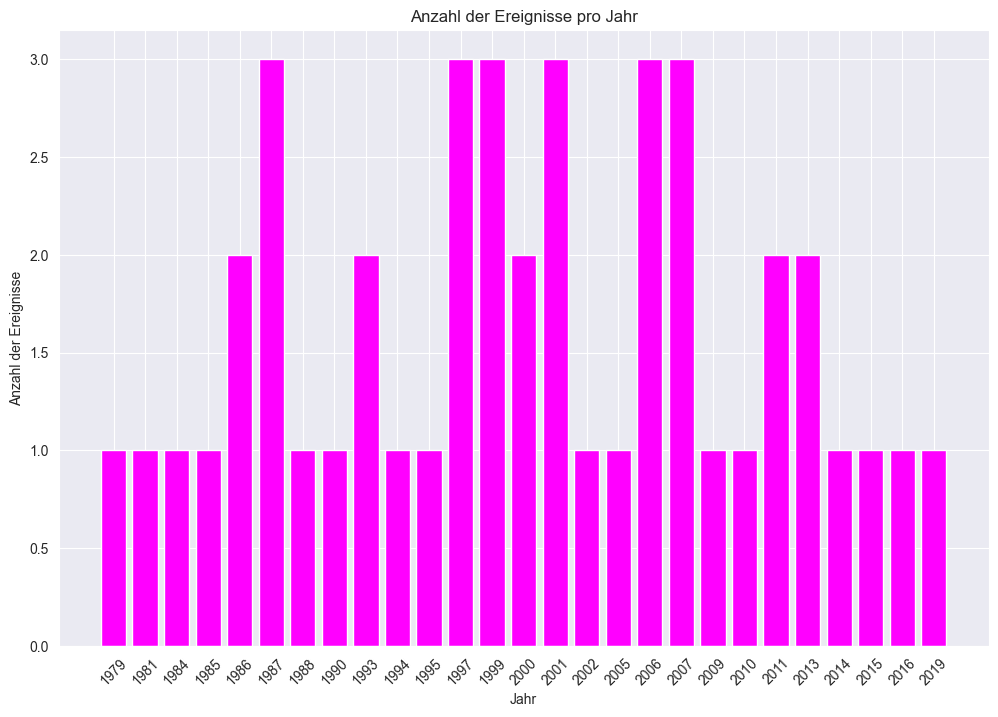

In [63]:
# Count the number of events per year
year_counts = data_hanze_ch['Year'].value_counts().sort_index()   # Sort by year for better visualization

# Create a bar chart
plt.figure(figsize=(12, 8))  
plt.bar(year_counts.index.astype(str), year_counts.values, color='magenta')  # Choose a color for the bars
plt.xlabel('Jahr') 
plt.ylabel('Anzahl der Ereignisse')  
plt.title('Anzahl der Ereignisse pro Jahr')  
plt.xticks(rotation=45)  # Rotate the x-axis labels if necessary
plt.show()

# Analyze the number of events per type
- In switzerland there are only two types of events: River and Flash.

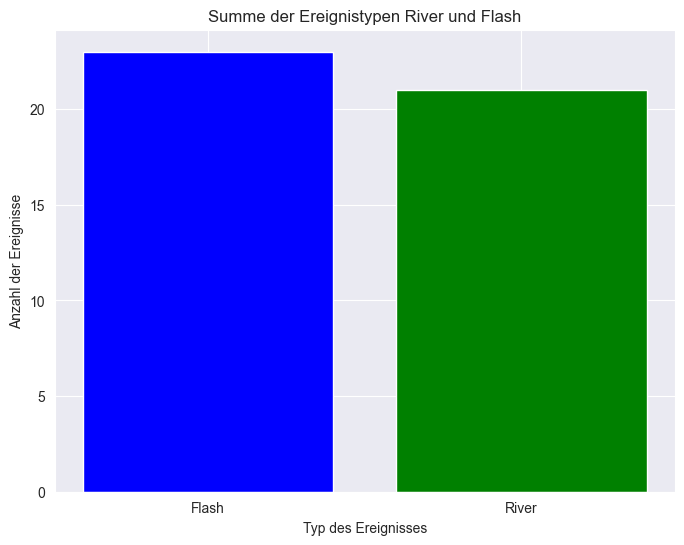

In [64]:
# Count the number of events per type
type_counts = data_hanze_ch['Type'].value_counts()

plt.figure(figsize=(8, 6))  
plt.bar(type_counts.index, type_counts.values, color=['blue', 'green'])  
plt.xlabel('Typ des Ereignisses')  
plt.ylabel('Anzahl der Ereignisse')  
plt.title('Summe der Ereignistypen River und Flash') 
plt.show()

# Explore the causes of events.

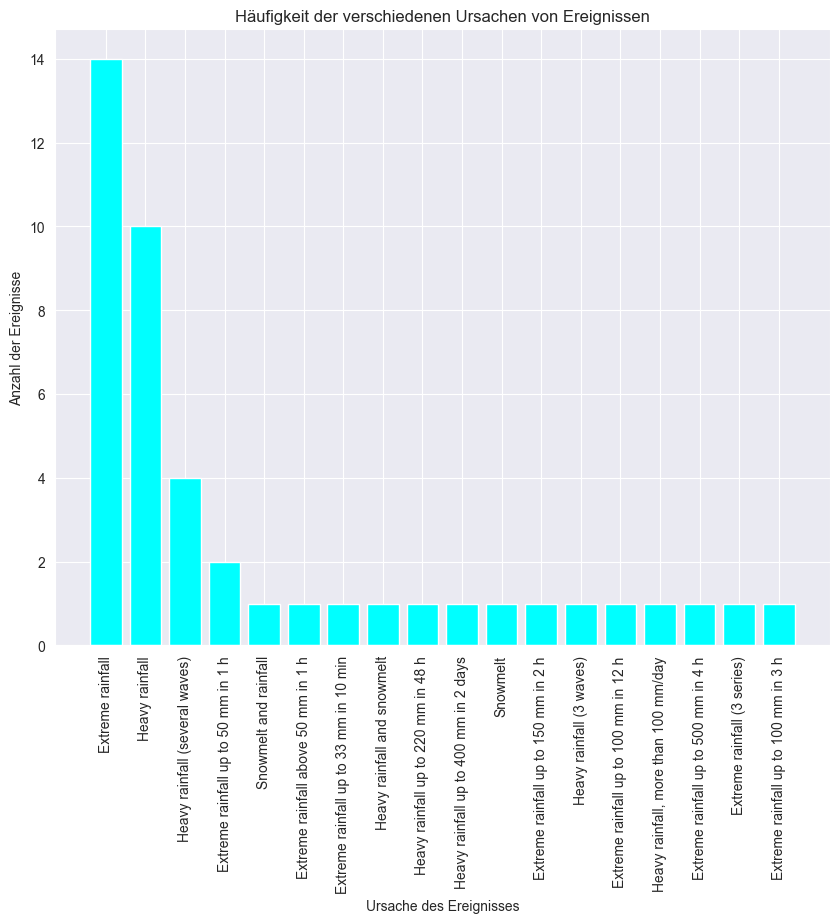

In [65]:
# Count the number of events per cause
cause_counts = data_hanze_ch['Cause'].value_counts()

plt.figure(figsize=(10, 8))  
plt.bar(cause_counts.index, cause_counts.values, color='cyan')  
plt.xlabel('Ursache des Ereignisses')
plt.ylabel('Anzahl der Ereignisse')  
plt.title('Häufigkeit der verschiedenen Ursachen von Ereignissen')
plt.xticks(rotation=90)  
plt.show()

In [66]:
from scipy.stats import chi2_contingency

# Create a cross-tabulation between two categorical variables
crosstab = pd.crosstab(data_hanze_ch['Type'], data_hanze_ch['Cause'])

# Perform the Chi-Square test of independence
chi2, p_value, dof, expected = chi2_contingency(crosstab)
print(f"Chi-Quadrat-Wert: {chi2}, p-Wert: {p_value}")

Chi-Quadrat-Wert: 44.0, p-Wert: 0.00034250394297158544


#### 1.	Correlation Coefficient Values:
-  1: Perfect positive correlation. As one variable increases, the other variable also increases.
-  0: No correlation. There is no linear relationship between the variables.
-  -1: Perfect negative correlation. As one variable increases, the other variable decreases.

#### 2.	Diagonal Elements (e.g., ID with ID):
-  he diagonal elements are all 1 because each variable is perfectly correlated with itself.

#### 3.	Off-Diagonal Elements:
-  D with Year: The correlation coefficient is 0.19. This indicates a weak positive correlation, meaning that as Year increases, ID tends to increase slightly.
-  ID with Duration: The correlation coefficient is -0.15. This indicates a weak negative correlation, meaning that as ID increases, Duration tends to decrease slightly.
-  Year with Duration: The correlation coefficient is 0.19. This indicates a weak positive correlation, meaning that as Year increases, Duration tends to increase slightly.

#### 4.	Color Coding:
-  The colors range from blue (negative correlation) to red (positive correlation).
-  Dark red (1.0) indicates a perfect positive correlation.
-  Dark blue (-1.0) would indicate a perfect negative correlation (though not present here).
-  Lighter shades closer to the middle of the color spectrum indicate weaker correlations.

                ID         Year   Duration
count    44.000000    44.000000  44.000000
mean   3106.477273  1999.613636   4.954545
std    1809.245230    10.448580   7.436411
min    1453.000000  1979.000000   0.000000
25%    1463.750000  1992.250000   1.000000
50%    2882.500000  2000.000000   1.000000
75%    3670.750000  2007.000000   5.500000
max    6031.000000  2019.000000  26.000000


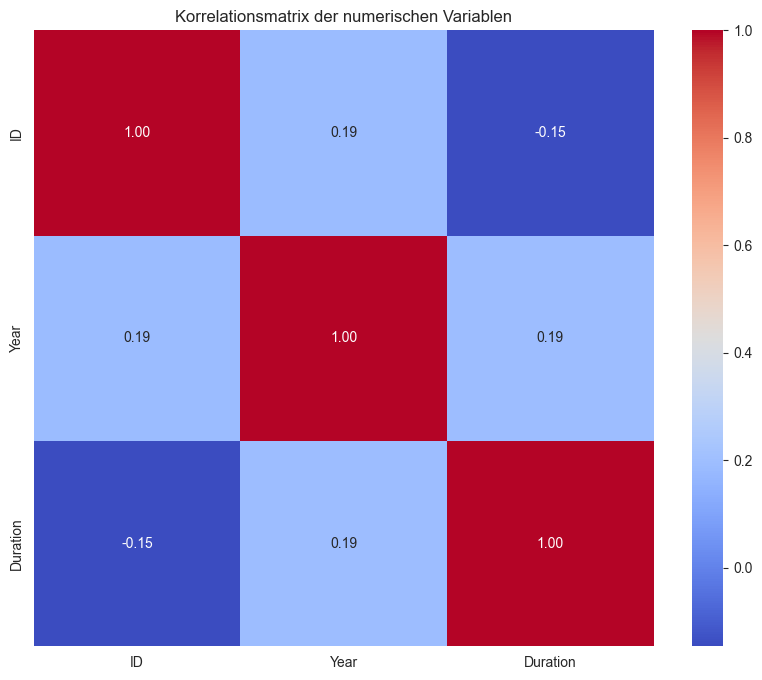

In [67]:
# Convert the 'Start date' and 'End date' columns to datetime
data_hanze_ch['Start date'] = pd.to_datetime(data_hanze_ch['Start date'], format='%Y-%m-%d')
data_hanze_ch['End date'] = pd.to_datetime(data_hanze_ch['End date'], format='%Y-%m-%d')

# Calculate the duration of events in days
data_hanze_ch['Duration'] = (data_hanze_ch['End date'] - data_hanze_ch['Start date']).dt.days

# Isolate the numeric columns for descriptive statistics
numeric_columns = data_hanze_ch.select_dtypes(include=[np.number])  # Ensure numpy is imported
print(numeric_columns.describe())

# Create a correlation matrix only for numeric variables
correlation_matrix = numeric_columns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Korrelationsmatrix der numerischen Variablen')
plt.show()

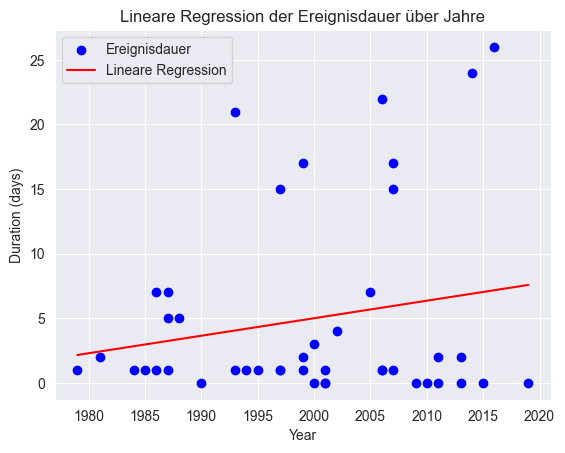

In [68]:
# Convert the date values into datetime objects
data_hanze_ch['Start date'] = pd.to_datetime(data_hanze_ch['Start date'], format='%Y-%m-%d')
data_hanze_ch['End date'] = pd.to_datetime(data_hanze_ch['End date'], format='%Y-%m-%d')

# Calculate the duration in days
data_hanze_ch["Duration"] = (data_hanze_ch["End date"] - data_hanze_ch["Start date"]).dt.days

# Preparation of the data for the regression
X = data_hanze_ch["Year"].values.reshape(-1, 1) 
y = data_hanze_ch["Duration"].values  

# Apply linear regression
reg = LinearRegression().fit(X, y)

# Predictions for the line
y_pred = reg.predict(X)

# Create plot
plt.scatter(X, y, color='blue', label='Ereignisdauer')
plt.plot(X, y_pred, color='red', label='Lineare Regression')
plt.xlabel("Year")
plt.ylabel("Duration (days)")
plt.title("Lineare Regression der Ereignisdauer über Jahre")
plt.legend()
plt.show()

In [69]:
data = pd.read_csv('../data/source/df_ch.csv', delimiter=';')

print(data)

         GRID_NO  LATITUDE  LONGITUDE  ALTITUDE       DAY  TEMPERATURE_MAX  TEMPERATURE_MIN  WINDSPEED  VAPOURPRESSURE  PRECIPITATION   ET0
0          79100  45.83319    6.99776      1889  19790101             -3.3            -17.7        8.3            2.96            0.4  1.04
1          79100  45.83319    6.99776      1889  19790102            -17.3            -21.3        5.2            1.15            3.7  0.19
2          79100  45.83319    6.99776      1889  19790103            -13.3            -17.3        8.0            1.68            0.7  0.26
3          79100  45.83319    6.99776      1889  19790104             -7.6            -15.2       10.1            2.20            2.5  0.88
4          79100  45.83319    6.99776      1889  19790105             -3.3             -7.3        4.7            4.12            0.1  0.25
...          ...       ...        ...       ...       ...              ...              ...        ...             ...            ...   ...
1660031    88105  47

# Data Collection and Cleaning

### **Data Completeness:** Check for gaps in the data, especially in historical records

In [70]:
#Missing values
missing = data.isnull().sum()
total_missing = missing.sum()

print(missing)
print(total_missing)

GRID_NO            0
LATITUDE           0
LONGITUDE          0
ALTITUDE           0
DAY                0
TEMPERATURE_MAX    0
TEMPERATURE_MIN    0
WINDSPEED          0
VAPOURPRESSURE     0
PRECIPITATION      0
ET0                0
dtype: int64
0


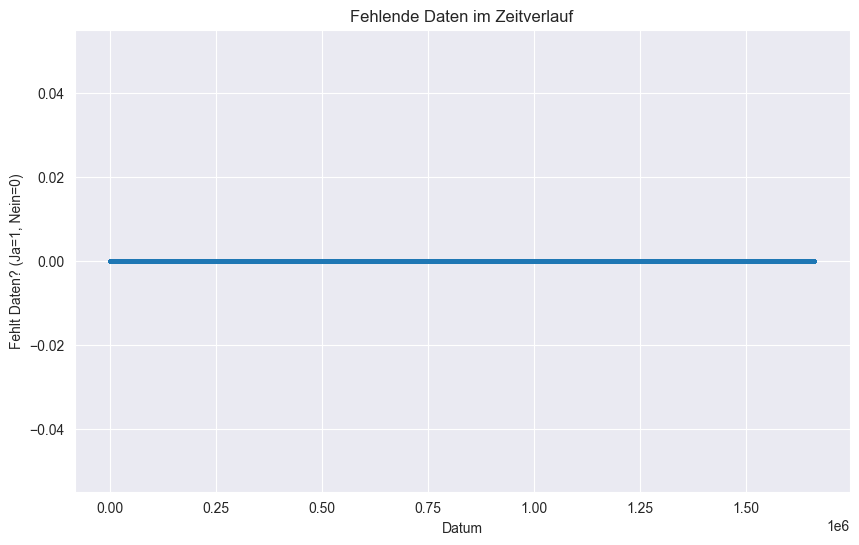

In [71]:
data['DAY'] = pd.to_datetime(data['DAY'], format='%Y%m%d')

plt.figure(figsize=(10, 6))
plt.plot(data.index, data.isnull(), 'o', markersize=2)
plt.title('Fehlende Daten im Zeitverlauf')
plt.xlabel('Datum')
plt.ylabel('Fehlt Daten? (Ja=1, Nein=0)')
plt.show()

### **Data Quality:** Identify possible errors or anomalies in the data (e.g., extremely high or low values that are outside of plausible ranges).

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1660036 entries, 0 to 1660035
Data columns (total 11 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   GRID_NO          1660036 non-null  int64         
 1   LATITUDE         1660036 non-null  float64       
 2   LONGITUDE        1660036 non-null  float64       
 3   ALTITUDE         1660036 non-null  int64         
 4   DAY              1660036 non-null  datetime64[ns]
 5   TEMPERATURE_MAX  1660036 non-null  float64       
 6   TEMPERATURE_MIN  1660036 non-null  float64       
 7   WINDSPEED        1660036 non-null  float64       
 8   VAPOURPRESSURE   1660036 non-null  float64       
 9   PRECIPITATION    1660036 non-null  float64       
 10  ET0              1660036 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(2)
memory usage: 139.3 MB
None
            GRID_NO      LATITUDE     LONGITUDE      ALTITUDE                            DAY  TE

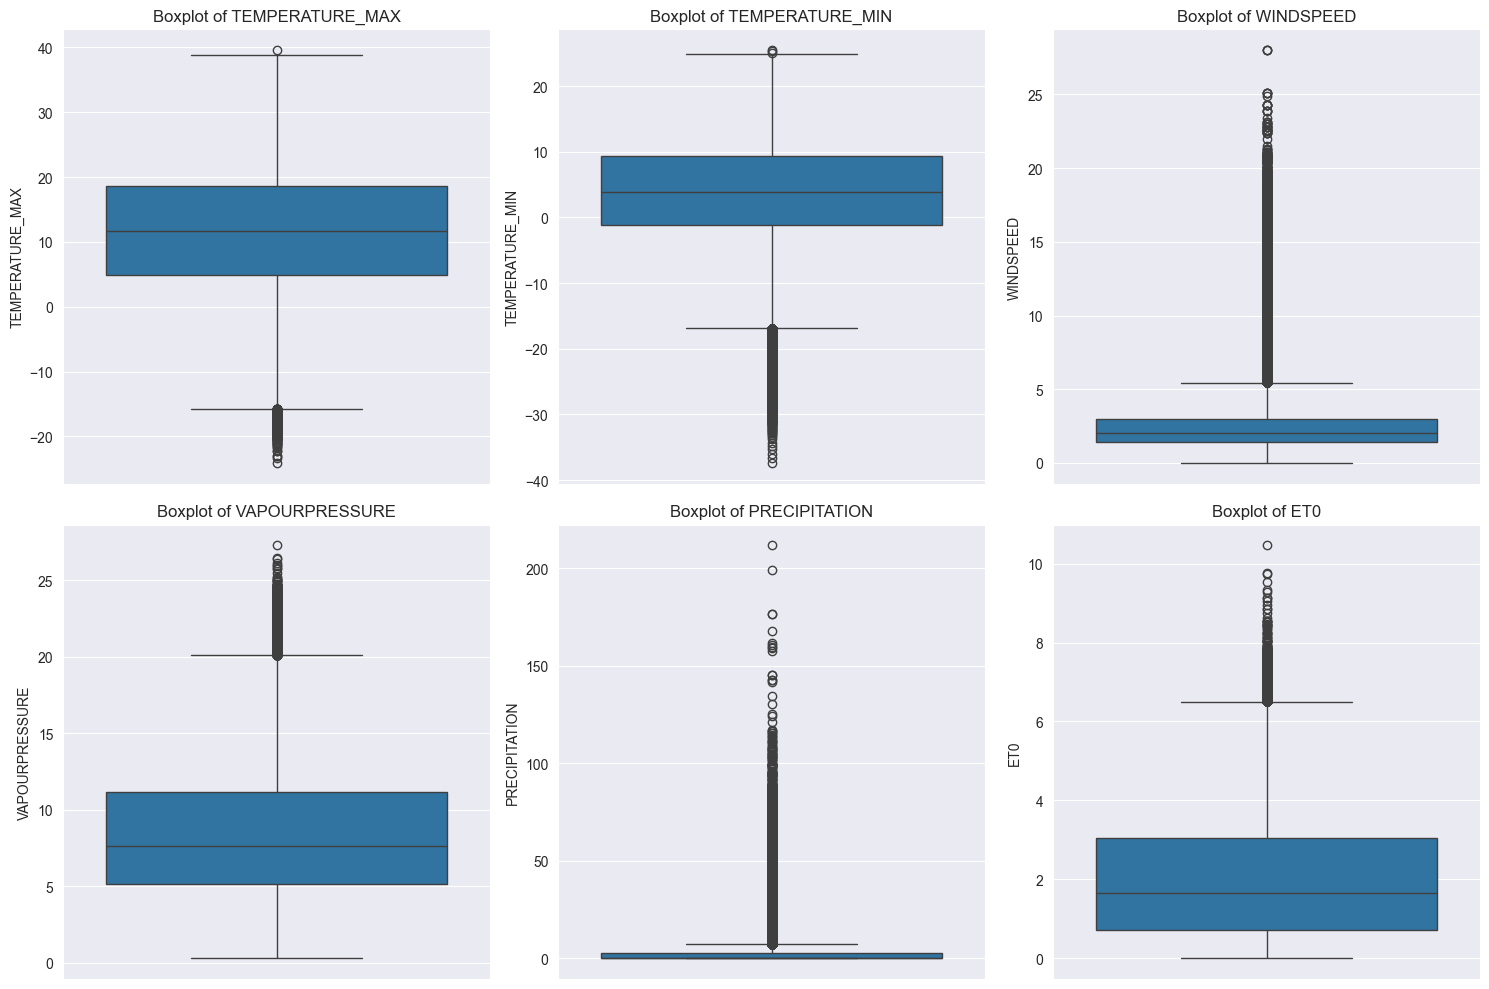

In [72]:
print(data.info())
print(data.describe())

df = data

# Boxplots for numeric columns
numerical_columns = ["TEMPERATURE_MAX", "TEMPERATURE_MIN", "WINDSPEED", "VAPOURPRESSURE", "PRECIPITATION", "ET0"]

plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

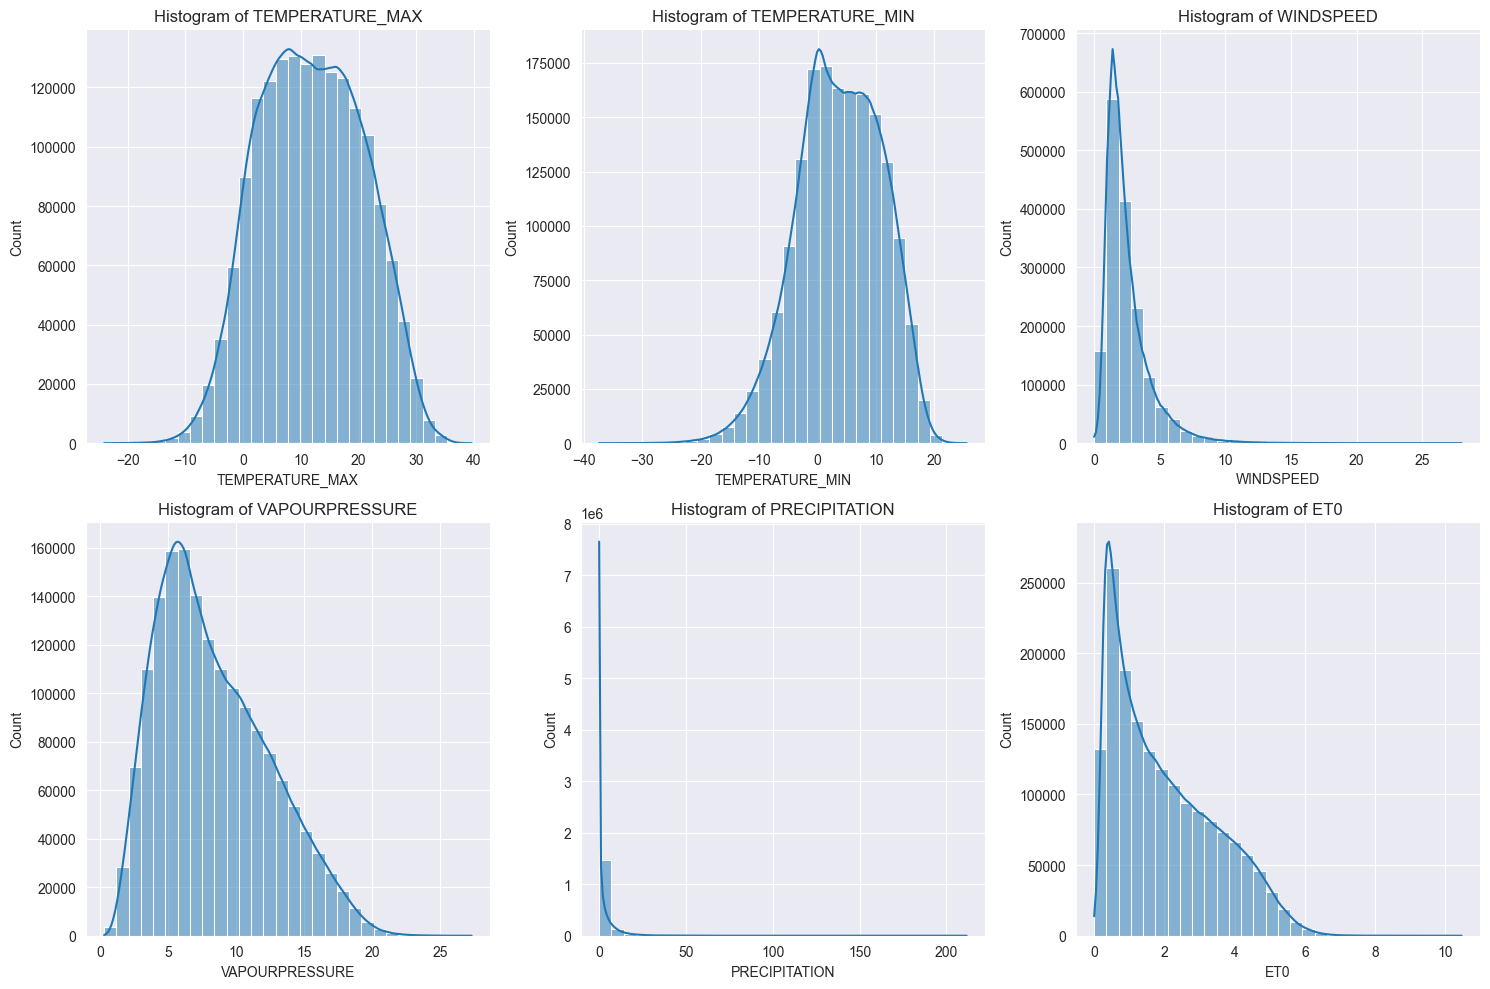

In [73]:
# Histogram for numeric columns
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[column], bins=30, kde=True)
    plt.title(f'Histogram of {column}')

plt.tight_layout()
plt.show()

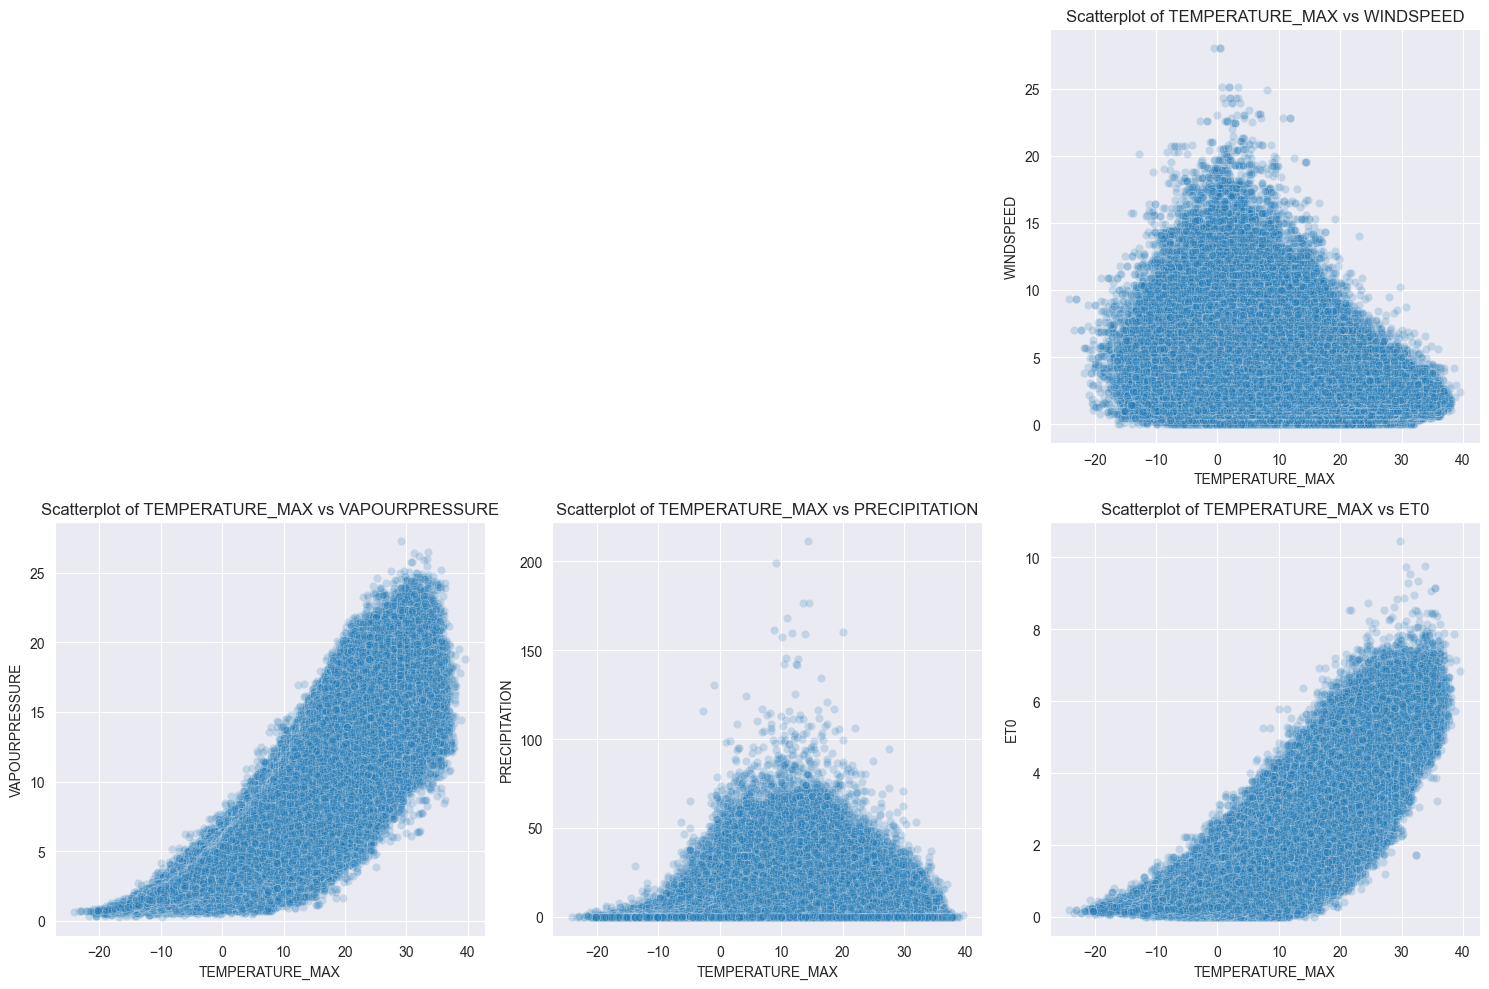

In [74]:
# Scatterplots between temperature and other variables
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns, 1):
    if column != "TEMPERATURE_MAX" and column != "TEMPERATURE_MIN":
        plt.subplot(2, 3, i)
        sns.scatterplot(x=df["TEMPERATURE_MAX"], y=df[column], alpha=0.2)
        plt.title(f'Scatterplot of TEMPERATURE_MAX vs {column}')

plt.tight_layout()
plt.show()

This correlation matrix visualizes the relationships between various meteorological variables in your dataset: TEMPERATURE_MAX, TEMPERATURE_MIN, WINDSPEED, VAPOURPRESSURE, PRECIPITATION, and ETO. The numbers and colors indicate the strength and direction of the correlations between these variables. Here is how to interpret the matrix:

#### Correlation Coefficient Values
-  1: Perfect positive correlation. As one variable increases, the other variable also increases.
-  0: No correlation. There is no linear relationship between the variables.
-  -1: Perfect negative correlation. As one variable increases, the other variable decreases.

#### Diagonal Elements
-  The diagonal elements are all 1 because each variable is perfectly correlated with itself.

#### Off-Diagonal Elements
-  TEMPERATURE_MAX with TEMPERATURE_MIN: The correlation coefficient is 0.89, indicating a strong positive correlation. This means higher maximum temperatures are associated with higher minimum temperatures.
-  TEMPERATURE_MAX with VAPOURPRESSURE: The correlation coefficient is 0.86, indicating a strong positive correlation.
-  TEMPERATURE_MAX with ETO: The correlation coefficient is 0.84, indicating a strong positive correlation.
-  TEMPERATURE_MIN with VAPOURPRESSURE: The correlation coefficient is 0.91, indicating a very strong positive correlation.
-  TEMPERATURE_MIN with ETO: The correlation coefficient is 0.70, indicating a strong positive correlation.
-  VAPOURPRESSURE with ETO: The correlation coefficient is 0.65, indicating a moderate positive correlation.
-  WINDSPEED with other variables: The correlations are generally weak to moderate, with the strongest being a negative correlation of -0.25 with TEMPERATURE_MAX.
-  PRECIPITATION with other variables: The correlations are generally weak, with the strongest being 0.15 with VAPOURPRESSURE.

#### Color Coding
-  Red (close to 1): Strong positive correlation.
-  Blue (close to -1): Strong negative correlation.
-  Lighter shades closer to the middle of the color spectrum (closer to 0): Weaker correlations.

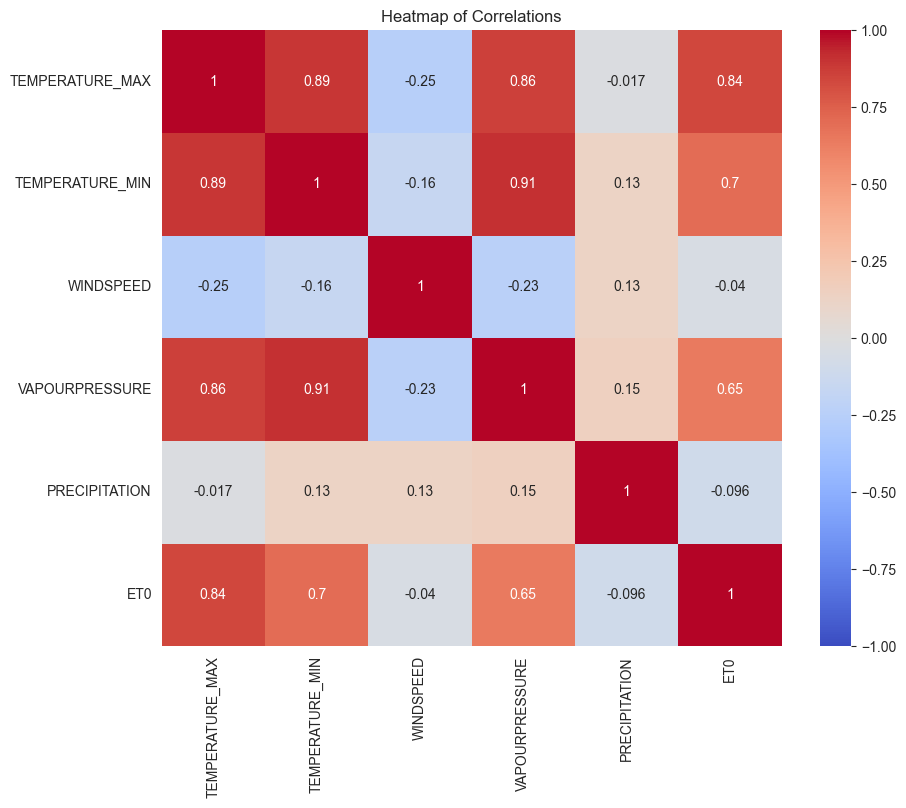

In [75]:
# Heatmap of correlations between numerical variables
plt.figure(figsize=(10, 8))
corr_matrix = df[numerical_columns].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Correlations')
plt.show()

# 2. Descriptive Statistics

### **Summary Statistics:** Mean, median, mode, minimum, and maximum of precipitation amounts.

In [76]:
# Calculate the summarised statistics for the precipitation quantities (Precipitation)

mean_precipitation = df['PRECIPITATION'].mean()
median_precipitation = df['PRECIPITATION'].median()
mode_precipitation = df['PRECIPITATION'].mode()[0] 
min_precipitation = df['PRECIPITATION'].min()
max_precipitation = df['PRECIPITATION'].max()

print(f"Mean of Precipitation: {mean_precipitation}")
print(f"Median of Precipitation: {median_precipitation}")
print(f"Mode of Precipitation: {mode_precipitation}")
print(f"Minimum of Precipitation: {min_precipitation}")
print(f"Maximum of Precipitation: {max_precipitation}")

Mean of Precipitation: 2.660440737429791
Median of Precipitation: 0.3
Mode of Precipitation: 0.0
Minimum of Precipitation: 0.0
Maximum of Precipitation: 211.6


### **Variance and Standard Deviation:** How much does precipitation vary?

In [77]:
variance_precipitation = df['PRECIPITATION'].var()
std_dev_precipitation = df['PRECIPITATION'].std()

# Output of variance and standard deviation
print(f"Variance of Precipitation: {variance_precipitation}")
print(f"Standard Deviation of Precipitation: {std_dev_precipitation}")


Variance of Precipitation: 30.26276517732388
Standard Deviation of Precipitation: 5.5011603482650715


# 3. Visual Data Analysis

### **Time Series Analysis:** Visualization of precipitation data over time to detect trends, seasonal patterns, and anomalies.

In [78]:
df['DATE'] = pd.to_datetime(df['DAY'], format='%Y%m%d')

# Set the date as an index
df.set_index('DATE', inplace=True)

print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1660036 entries, 1979-01-01 to 2023-12-31
Data columns (total 11 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   GRID_NO          1660036 non-null  int64         
 1   LATITUDE         1660036 non-null  float64       
 2   LONGITUDE        1660036 non-null  float64       
 3   ALTITUDE         1660036 non-null  int64         
 4   DAY              1660036 non-null  datetime64[ns]
 5   TEMPERATURE_MAX  1660036 non-null  float64       
 6   TEMPERATURE_MIN  1660036 non-null  float64       
 7   WINDSPEED        1660036 non-null  float64       
 8   VAPOURPRESSURE   1660036 non-null  float64       
 9   PRECIPITATION    1660036 non-null  float64       
 10  ET0              1660036 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(2)
memory usage: 152.0 MB
None
            GRID_NO      LATITUDE     LONGITUDE      ALTITUDE                    

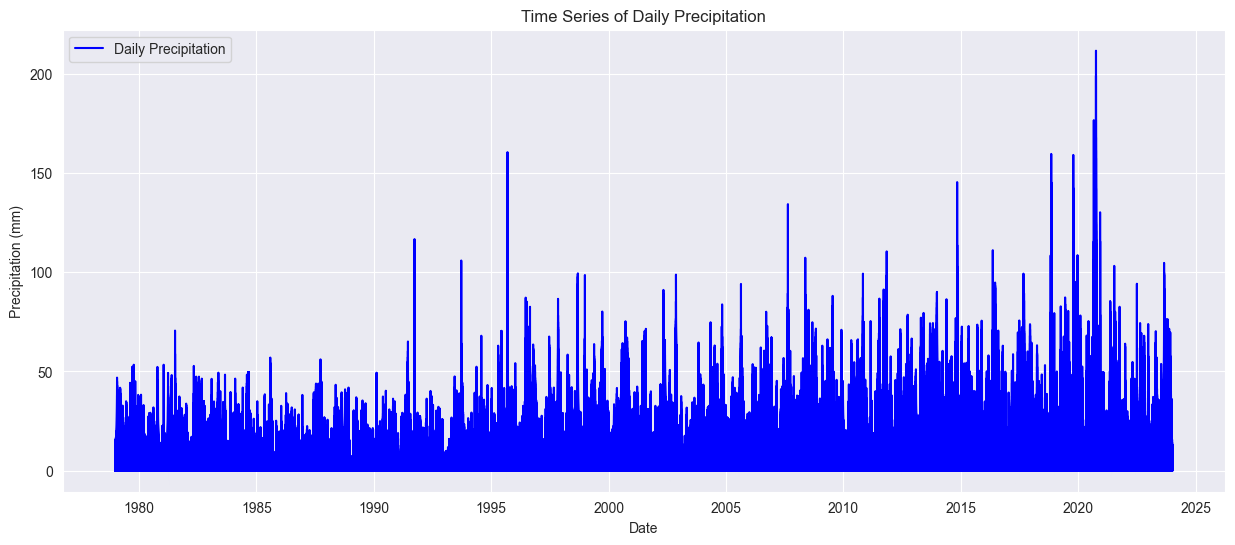

In [79]:
# Time series plot for precipitation data
plt.figure(figsize=(15, 6))
plt.plot(df['PRECIPITATION'], color='blue', label='Daily Precipitation')
plt.title('Time Series of Daily Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.legend()
plt.show()

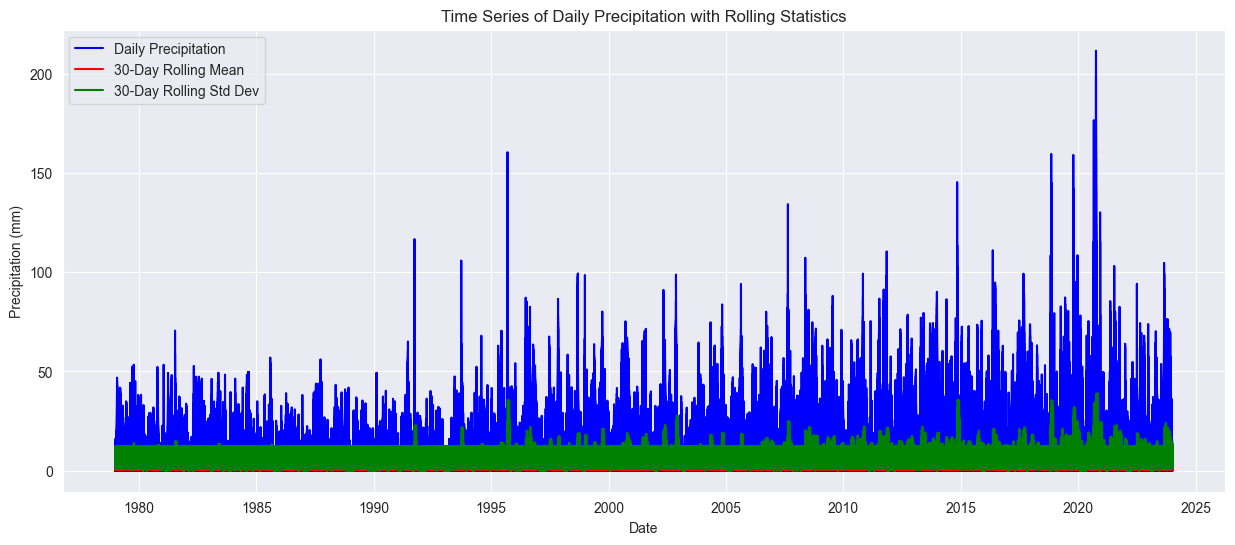

In [80]:
# Calculate rolling mean and rolling standard deviation (e.g. 30-day window)
rolling_mean = df['PRECIPITATION'].rolling(window=30).mean()
rolling_std = df['PRECIPITATION'].rolling(window=30).std()

# Plot mit Rolling Mean und Rolling Standard Deviation
plt.figure(figsize=(15, 6))
plt.plot(df['PRECIPITATION'], color='blue', label='Daily Precipitation')
plt.plot(rolling_mean, color='red', label='30-Day Rolling Mean')
plt.plot(rolling_std, color='green', label='30-Day Rolling Std Dev')
plt.title('Time Series of Daily Precipitation with Rolling Statistics')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.legend()
plt.show()

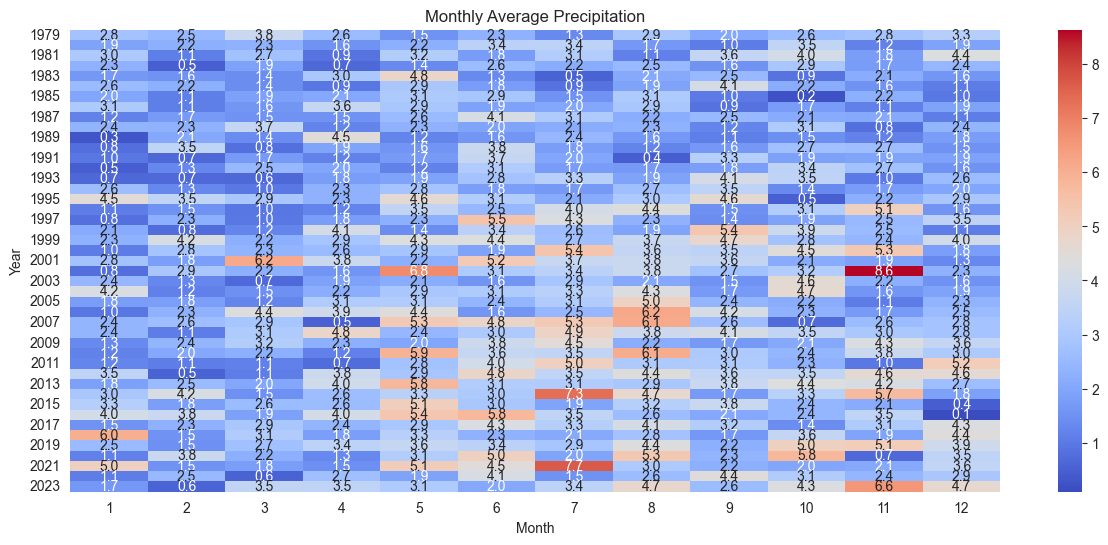

In [81]:
# Calculate and plot seasonal averages
df['Year'] = df.index.year
df['Month'] = df.index.month
monthly_mean = df.groupby(['Year', 'Month'])['PRECIPITATION'].mean().unstack()

plt.figure(figsize=(15, 6))
sns.heatmap(monthly_mean, cmap='coolwarm', annot=True, fmt=".1f")
plt.title('Monthly Average Precipitation')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

### **Histograms:** Distribution of precipitation intensities.

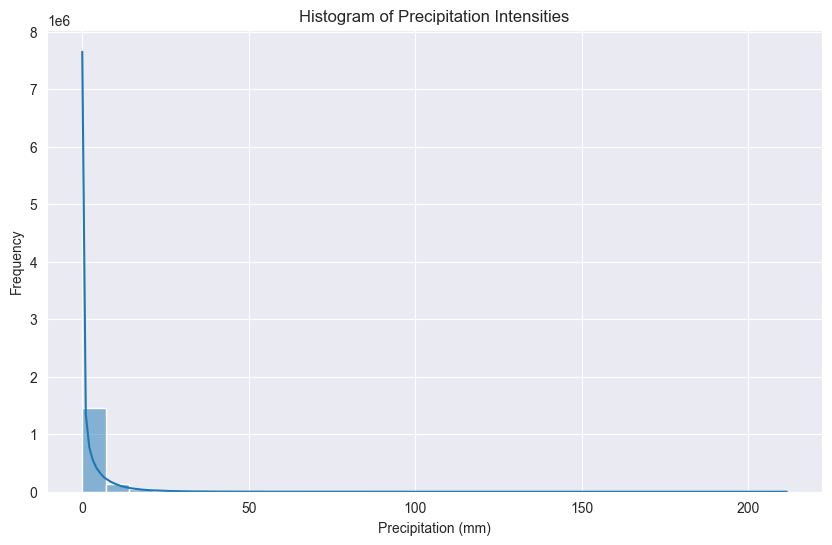

In [82]:
# Histogram for precipitation intensities
plt.figure(figsize=(10, 6))
sns.histplot(df['PRECIPITATION'], bins=30, kde=True)
plt.title('Histogram of Precipitation Intensities')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Frequency')
plt.show()

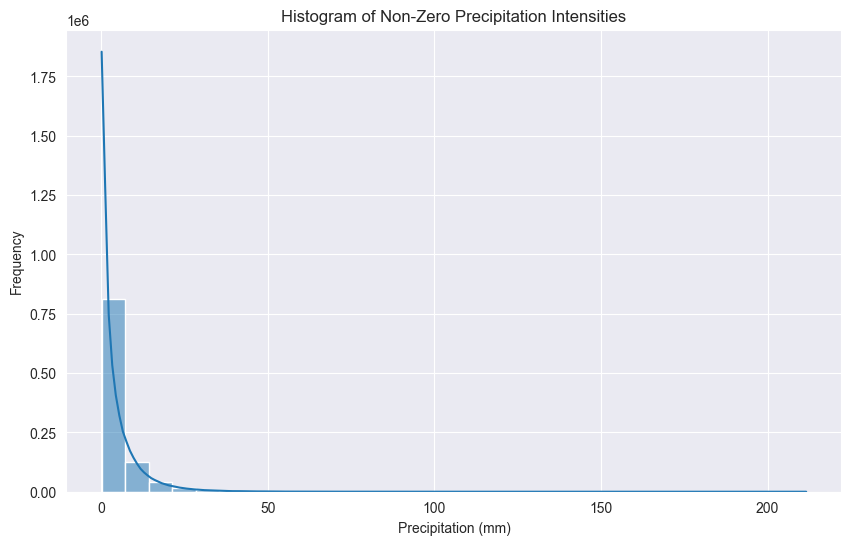

In [83]:
# Histogram for precipitation intensities without values of 0
plt.figure(figsize=(10, 6))
sns.histplot(df[df['PRECIPITATION'] > 0]['PRECIPITATION'], bins=30, kde=True)
plt.title('Histogram of Non-Zero Precipitation Intensities')
plt.xlabel('Precipitation (mm)')
plt.ylabel('Frequency')
plt.show()

### **Boxplots:** To visualize the distribution of precipitation amounts and identify outliers.

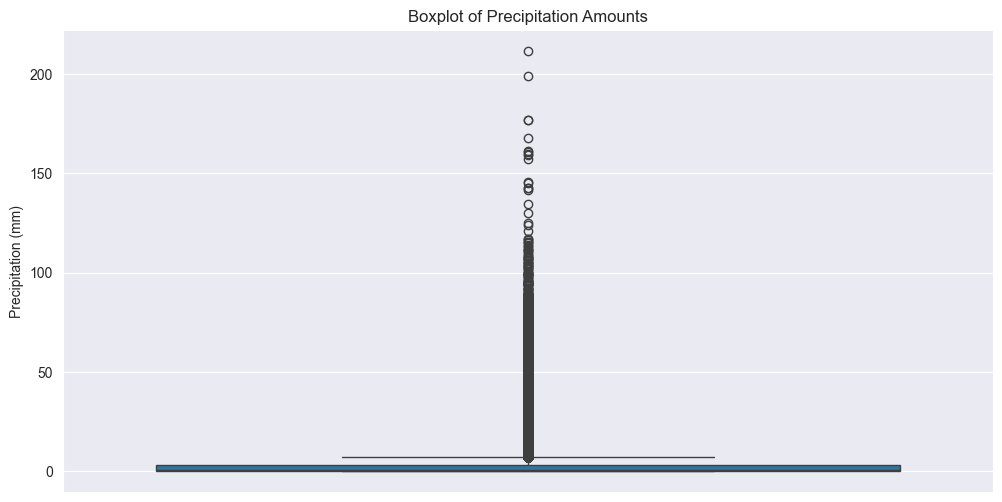

In [84]:
# Setting the figure size for better visibility
plt.figure(figsize=(12, 6))

# Creating a boxplot for the precipitation data
sns.boxplot(y=df['PRECIPITATION'])

plt.title('Boxplot of Precipitation Amounts')
plt.ylabel('Precipitation (mm)')

plt.show()

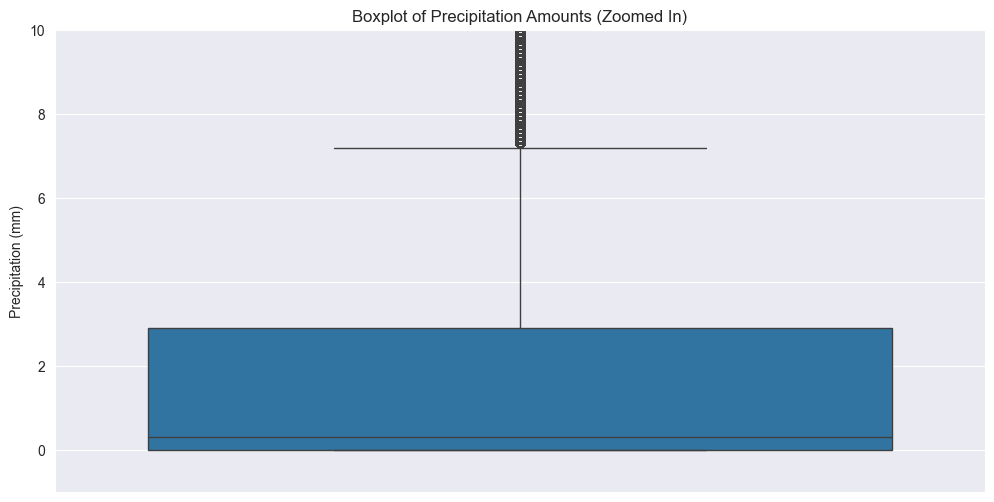

In [85]:
# Setting the figure size for better visibility
plt.figure(figsize=(12, 6))

# Creating a boxplot for the precipitation data with a limited y-axis
sns.boxplot(y=df['PRECIPITATION'])

plt.title('Boxplot of Precipitation Amounts (Zoomed In)')
plt.ylabel('Precipitation (mm)')

# Limiting the y-axis to focus on the central part of the data
plt.ylim(-1, 10)

plt.show()

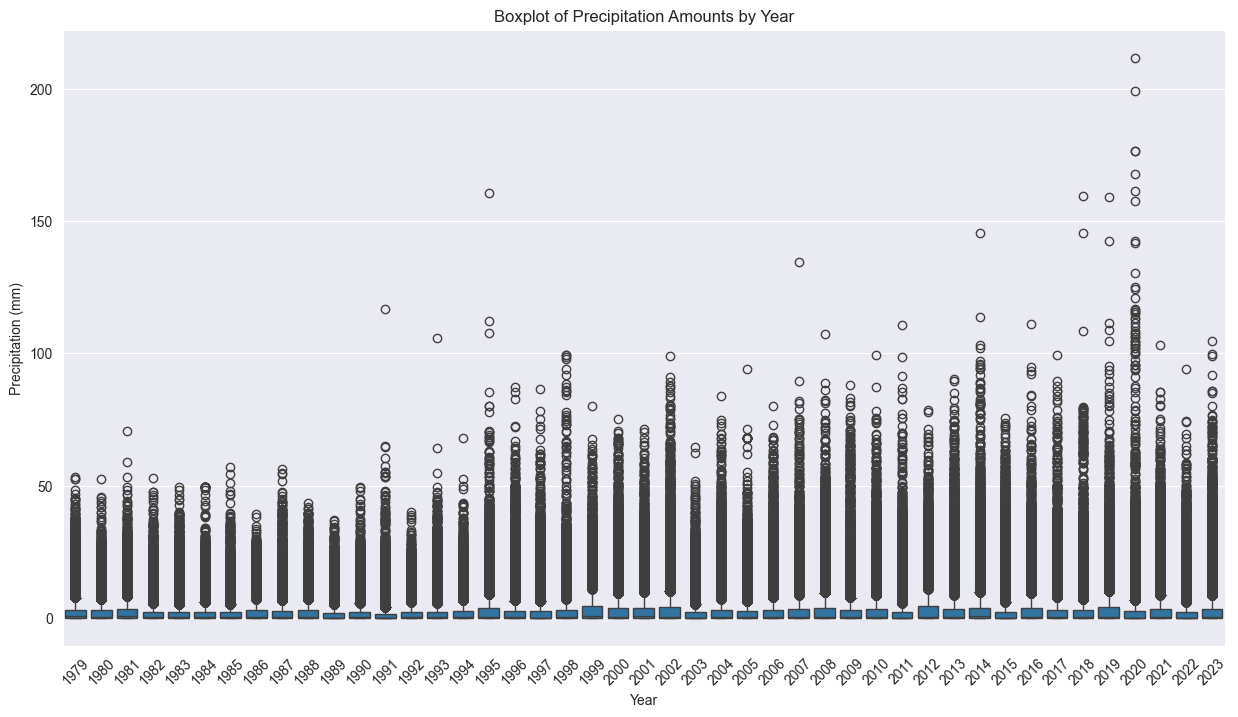

In [86]:
plt.figure(figsize=(15, 8))
sns.boxplot(x=df['Year'], y=df['PRECIPITATION'])
plt.title('Boxplot of Precipitation Amounts by Year')
plt.xlabel('Year')
plt.ylabel('Precipitation (mm)')
plt.xticks(rotation=45)
plt.show()

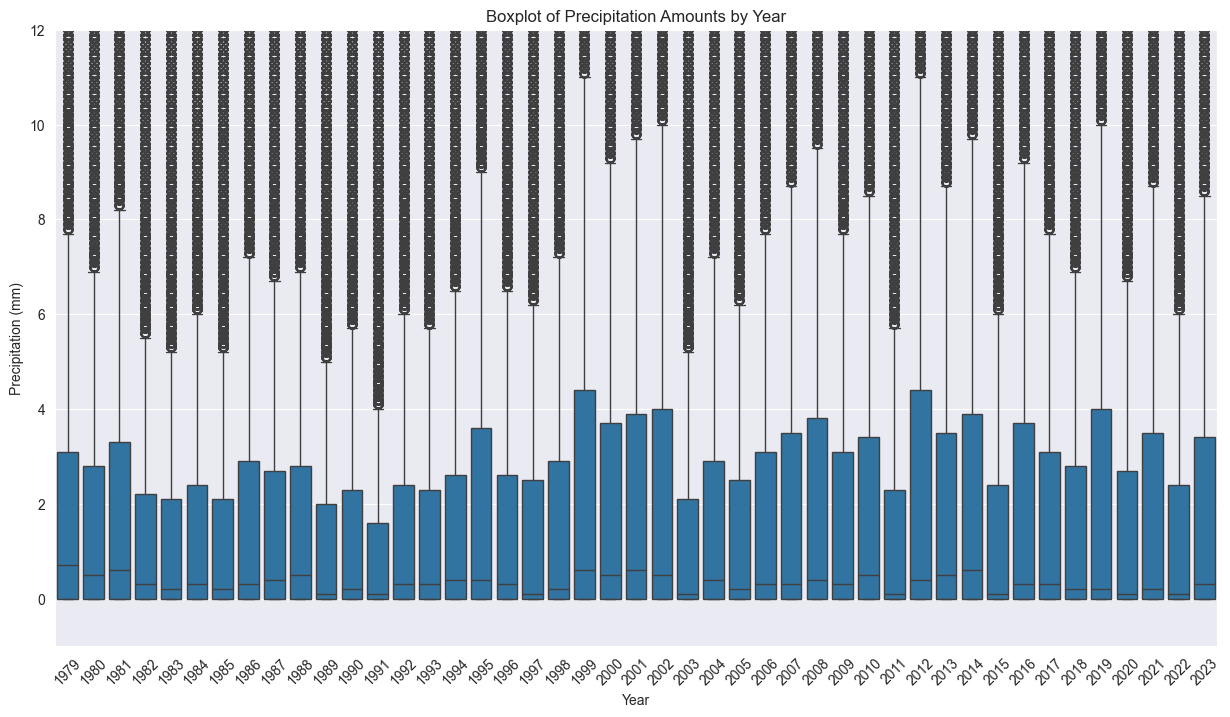

In [87]:
plt.figure(figsize=(15, 8))
sns.boxplot(x=df['Year'], y=df['PRECIPITATION'])
plt.title('Boxplot of Precipitation Amounts by Year')
plt.xlabel('Year')
plt.ylabel('Precipitation (mm)')
plt.xticks(rotation=45)

# Limiting the y-axis to focus on the central part of the data
plt.ylim(-1, 12)

plt.show()

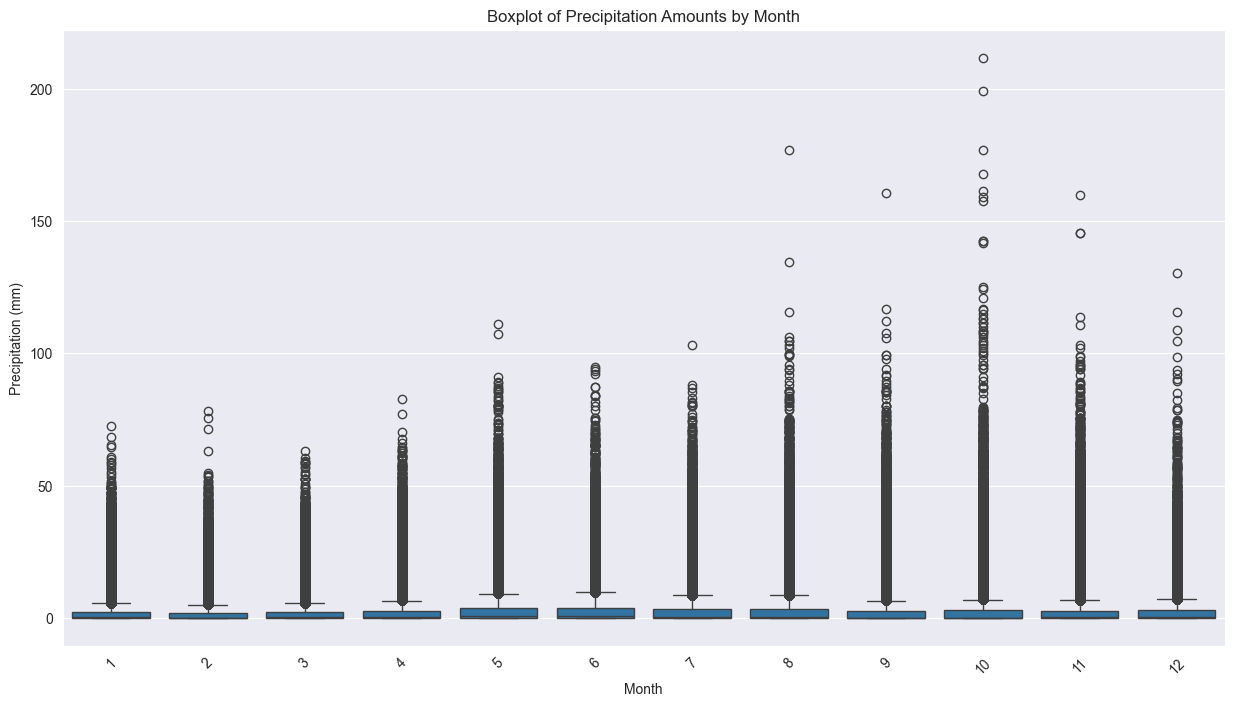

In [88]:
# Boxplot for precipitation amounts by month
plt.figure(figsize=(15, 8))
sns.boxplot(x=df['Month'], y=df['PRECIPITATION'])
plt.title('Boxplot of Precipitation Amounts by Month')
plt.xlabel('Month')
plt.ylabel('Precipitation (mm)')
plt.xticks(rotation=45)
plt.show()

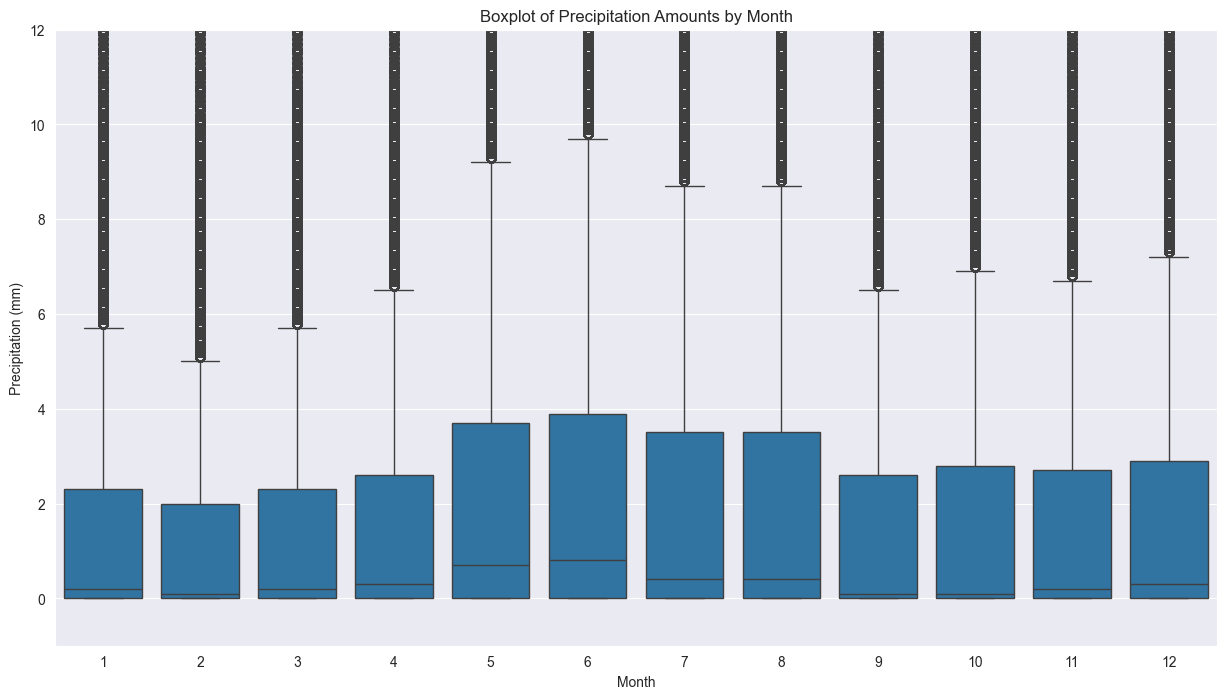

In [89]:
# Boxplot for precipitation amounts by month
plt.figure(figsize=(15, 8))
sns.boxplot(x=df['Month'], y=df['PRECIPITATION'])
plt.title('Boxplot of Precipitation Amounts by Month')
plt.xlabel('Month')
plt.ylabel('Precipitation (mm)')

# Limiting the y-axis to focus on the central part of the data
plt.ylim(-1, 12)

plt.show()

### **Map-based Visualizations:** Geographic representation of precipitation data and flood areas.

In [90]:
import pandas as pd
import folium
from folium.plugins import HeatMap
from IPython.display import display, IFrame
import ast

# Extract precipitation data
precipitation_data = data[['LATITUDE', 'LONGITUDE', 'PRECIPITATION']].values.tolist()

# Create a map centered on Switzerland
map_center = [46.8182, 8.2275]  # Center of Switzerland
m = folium.Map(location=map_center, zoom_start=8)

# Add precipitation data as a heatmap
HeatMap(precipitation_data, radius=10).add_to(m)

# Display the map inline in the notebook
m

In [91]:
import pandas as pd
import folium
from folium.plugins import HeatMap

# Initialize a map centered around Switzerland
m = folium.Map(location=[46.8182, 8.2275], zoom_start=8)

# Add HeatMap for each set of coordinates in 'Regions affected (v2021)'
for regions in data_hanze_ch['Regions affected (v2021)']:
    HeatMap(regions, radius=10, blur=15, gradient={0.4: 'blue', 0.65: 'lime', 1: 'red'}).add_to(m)

# Display the map
m